In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec
from datetime import datetime


In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
with open('../models/TVAE_synthesizer.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [4]:
# check out sample
N = 100000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [5]:
df_input = pd.read_csv('../data/cc_data_input.csv')

In [6]:
input_columns = list(df_input.columns)[1:]

In [7]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 45)
df_sample.head()

,Purchase Amount,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,period_of_month_end,period_of_month_mid,period_of_month_start,"Age Range_(20, 25]","Age Range_(25, 30]","Age Range_(30, 35]","Age Range_(35, 40]","Age Range_(40, 45]","Age Range_(45, 50]","Age Range_(50, 55]","Age Range_(55, 60]","Age Range_(60, 65]","Age Range_(65, 70]",retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,-0.654590,0.999961,-0.000179,1.000134,-0.000108,-0.000051,0.000051,0.999878,-0.000117,0.000112,0.000014,-0.000002,-0.000078,0.000134,0.000024,-0.000119,0.000038,-0.000034,-0.000017,3.934564e-05,-0.000068,-0.000028,0.000092,-0.000054,0.000031,-0.000017,-0.000008,-0.000046,-0.000048,-0.000043,0.000068,-0.000091,0.000028,-0.000004,-2.945103e-05,1.293544,-0.692750,-1.121293,1.215071,-2.265143,-1.898077,-0.219916,-2.464783,-1.773039,0.103320
1,11.692895,1.000025,0.000046,-0.000066,0.999859,0.000070,0.000013,-0.000023,0.000147,0.000126,-0.000012,-0.000074,-0.000054,0.000088,0.000017,0.000018,-0.000042,0.000021,0.000117,-2.760967e-05,0.000093,-0.000034,-0.000076,0.000027,0.000170,0.000009,0.000064,0.000057,0.000170,0.000128,0.000051,0.000008,0.000030,-0.000030,-6.706171e-07,-0.165110,-1.703525,-0.499323,-0.440117,-0.503349,-2.412174,-0.571311,-2.707265,-1.840951,1.231971
2,2.691751,1.000027,-0.000049,-0.000353,0.999994,-0.000005,0.000092,-0.000096,-0.000081,0.000049,0.000089,1.000085,-0.000109,-0.000139,-0.000071,-0.000018,0.000043,-0.000002,0.000112,4.997131e-07,-0.000115,-0.000085,0.000013,-0.000020,0.000005,-0.000068,0.000084,-0.000043,-0.000022,-0.000041,0.000053,-0.000069,-0.000027,-0.000047,-1.589363e-05,-1.000019,-2.216451,-2.061502,-1.231175,-0.686869,-1.954868,-0.569959,-1.607174,-1.668286,-1.639710
3,11.214237,1.000066,-0.000129,0.999897,-0.000183,0.000052,-0.000026,0.000017,-0.000016,0.000068,0.000037,0.999994,-0.000026,-0.000039,0.000053,0.000049,0.000049,-0.000011,-0.000003,7.763434e-05,0.000022,-0.000086,-0.000036,0.000130,0.000050,0.000066,-0.000046,-0.000174,0.000040,0.000008,0.000104,0.000060,-0.000085,-0.000051,-6.373057e-06,-0.466998,-0.756639,-0.776476,-0.676372,0.994398,-2.599366,0.290364,-1.675357,-0.310906,-1.114500
4,14.440783,1.000135,0.000023,0.000009,0.999840,0.000042,0.000039,0.000045,-0.000030,-0.000047,-0.000026,-0.000116,-0.000069,1.000289,0.000018,0.000068,-0.000047,0.000073,0.000010,-5.215135e-05,0.000103,0.000026,-0.000119,0.000023,0.000142,0.000054,-0.000066,0.000035,-0.000117,0.000053,-0.000085,0.000061,0.000046,-0.000067,-1.309753e-07,0.601206,0.522157,3.081186,1.941234,1.085890,-1.473010,0.424556,-3.202620,-3.717231,-3.265607


In [8]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for absolute max in each row and put into one series
    df_output = pd.Series(tmp.abs().idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [9]:
#df_purchase = df_sample.iloc[:,[0,1]]
df_purchase = df_sample.iloc[:,[0]]
df_age = reverse_dummy(df_sample,'Age Range')
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [10]:
#df_reverse = pd.concat([df_purchase,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)
df_reverse = pd.concat([df_purchase,df_age,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(100000, 7)


,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,-0.654590,"(50, 55]",bank_account,female,Drug Stores and Proprietary Stores,Friday,end
1,11.692895,"(35, 40]",bank_account,male,Eating Places,Sunday,start
2,2.691751,"(25, 30]",bank_account,male,Grocery Stores,Tuesday,mid
3,11.214237,"(30, 35]",bank_account,female,Grocery Stores,Wednesday,mid
4,14.440783,"(35, 40]",bank_account,male,Other,Tuesday,start


In [11]:
def return_age(age_range):
    age_range = age_range.replace('(','').replace(']','').replace(' ','')
    r1 = int(age_range.split(',')[0])
    r2 = int(age_range.split(',')[1])
    return random.choice(list(range(r1+1, r2+1)))

In [12]:
df_reverse['Age'] = df_reverse.apply(lambda x: return_age(x['Age Range']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age
0,-0.654590,"(50, 55]",bank_account,female,Drug Stores and Proprietary Stores,Friday,end,54
1,11.692895,"(35, 40]",bank_account,male,Eating Places,Sunday,start,39
2,2.691751,"(25, 30]",bank_account,male,Grocery Stores,Tuesday,mid,27
3,11.214237,"(30, 35]",bank_account,female,Grocery Stores,Wednesday,mid,34
4,14.440783,"(35, 40]",bank_account,male,Other,Tuesday,start,38


In [13]:
#df_reverse['SIC Description'].value_counts()[:9].index.tolist()

In [14]:
##retailer_map_grouped
#for i in range(0,100):
#    word_list = retailer_map_grouped[df_SIC_vector['SIC Description'][i]]
#    print(df_SIC_vector['SIC Description'][i])
#    min_idx = model.wv.distances(df_SIC_vector['retailerVec'][i], other_words = word_list).argmin()
#    print(word_list[min_idx])
#    print('\n')

In [15]:
# load the retailer_map
with open('../models/retailer_map_grouped.pkl', 'rb') as input:
    retailer_map_grouped = pickle.load(input)  

In [16]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]  

# put retailer vectors into one column
df_retailerVec['retailerVec'] = df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_reverse['SIC Description'], df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SIC Description,retailerVec
0,Drug Stores and Proprietary Stores,"[1.2935444353935683, -0.6927499329360031, -1.1..."
1,Eating Places,"[-0.16510979161328013, -1.7035254586787236, -0..."
2,Grocery Stores,"[-1.0000193562037027, -2.2164510139838014, -2...."
3,Grocery Stores,"[-0.46699843506703953, -0.7566392508396733, -0..."
4,Other,"[0.6012056757137482, 0.5221566677046672, 3.081..."


In [17]:
retailer_map_grouped.keys()
#retailer_map_grouped['Gasoline Service Stations']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [18]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [19]:
model = Word2Vec.load('../models/retailer_embedding.model')
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head(10)

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer
0,-0.654590,"(50, 55]",bank_account,female,Drug Stores and Proprietary Stores,Friday,end,54,Shoppers Drug Mart
1,11.692895,"(35, 40]",bank_account,male,Eating Places,Sunday,start,39,Paesano Pizza
2,2.691751,"(25, 30]",bank_account,male,Grocery Stores,Tuesday,mid,27,Remark Fresh Markets
3,11.214237,"(30, 35]",bank_account,female,Grocery Stores,Wednesday,mid,34,KAUFLAND
4,14.440783,"(35, 40]",bank_account,male,Other,Tuesday,start,38,Saint Laurent
5,76.501015,"(25, 30]",bank_account,female,Gasoline Service Stations,Wednesday,start,28,Blanchard's
6,4.565122,"(20, 25]",credit_card,female,Grocery Stores,Wednesday,end,21,Kwik Way
7,4.357756,"(35, 40]",bank_account,male,Eating Places,Wednesday,end,37,Tim Hortons
8,53.708229,"(35, 40]",bank_account,male,Other,Friday,mid,38,TELUS
9,86.123465,"(45, 50]",bank_account,female,Grocery Stores,Friday,end,47,Foodland


In [20]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [21]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date
0,-0.654590,"(50, 55]",bank_account,female,Drug Stores and Proprietary Stores,Friday,end,54,Shoppers Drug Mart,2022-02-25
1,11.692895,"(35, 40]",bank_account,male,Eating Places,Sunday,start,39,Paesano Pizza,2022-02-06
2,2.691751,"(25, 30]",bank_account,male,Grocery Stores,Tuesday,mid,27,Remark Fresh Markets,2022-02-15
3,11.214237,"(30, 35]",bank_account,female,Grocery Stores,Wednesday,mid,34,KAUFLAND,2022-02-16
4,14.440783,"(35, 40]",bank_account,male,Other,Tuesday,start,38,Saint Laurent,2022-02-01


In [22]:
print(df_reverse['day_of_week'].value_counts())
print(df_reverse['period_of_month'].value_counts())

Friday       16059
Saturday     15327
Thursday     14697
Monday       13799
Wednesday    13696
Tuesday      13545
Sunday       12877
Name: day_of_week, dtype: int64
end      36751
mid      32366
start    30883
Name: period_of_month, dtype: int64


In [23]:
# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

# load processed input data to check mean purchase amount for each retailer
df_processed = pd.read_csv('../data/cc_data_processed.csv')
df_processed.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date,Age
0,credit_card,male,Red Robin,Eating Places,15.52,2019-07-01,22.0
1,bank_account,male,California Thai,Eating Places,11.29,2019-09-30,30.0
2,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,2019-06-24,34.0
3,bank_account,female,The Beer Store,Other,88.90,2018-10-01,43.0
4,bank_account,male,Intermarche,Grocery Stores,23.54,2019-12-01,62.0


In [24]:
#df_processed_G = df_processed.groupby('Normalized Retailer').agg({'Purchase Amount': {'size', 'mean'}})
#df_processed_G.sort_values([('Purchase Amount','size')], ascending=False)

In [25]:
# create columns that are mean_byRetailer_input, mean_byRetailer_syn, and apply their ratio to adjust Purchase Amount
df_reverse['mean_byRetailer_syn'] = df_reverse['Normalized Retailer'].map(df_reverse.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['mean_byRetailer_input'] = df_reverse['Normalized Retailer'].map(df_processed.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['Purchase Amount Corrected'] = df_reverse.apply(lambda x: x['Purchase Amount'] * x.mean_byRetailer_input / x.mean_byRetailer_syn, axis = 1)

In [26]:
# drop intermediate values
col2drop = ['Age Range','day_of_week','period_of_month','mean_byRetailer_syn','mean_byRetailer_input']
df_reverse.drop(col2drop, axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Account Type,Consumer Gender,SIC Description,Age,Normalized Retailer,Transaction Date,Purchase Amount Corrected
0,11.692895,bank_account,male,Eating Places,39,Paesano Pizza,2022-02-06,50.961615
1,2.691751,bank_account,male,Grocery Stores,27,Remark Fresh Markets,2022-02-15,5.218373
2,11.214237,bank_account,female,Grocery Stores,34,KAUFLAND,2022-02-16,6.306936
3,14.440783,bank_account,male,Other,38,Saint Laurent,2022-02-01,108.401972
4,76.501015,bank_account,female,Gasoline Service Stations,28,Blanchard's,2022-02-09,46.340953


In [27]:
# save synthesized data into csv file
#output_filename = str(Y) + '_' + datetime.strptime(str(M), "%m").strftime("%b") + '.csv'
#df_reverse.to_csv('output/' + output_filename)

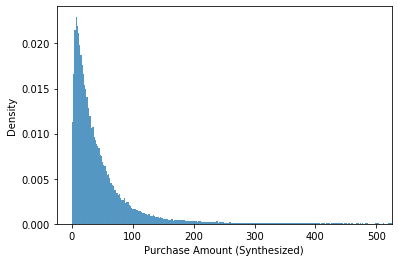

In [28]:
#sns.histplot(df_reverse['Purchase Amount'], stat="probability");
ax = sns.histplot(df_reverse['Purchase Amount Corrected'], stat="density");
plt.xlim(-25, 525);
ax.set(xlabel='Purchase Amount (Synthesized)');
#plt.savefig('figs/eda/purchase_hist_syn_ageCat70_corr.png',bbox_inches='tight')

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


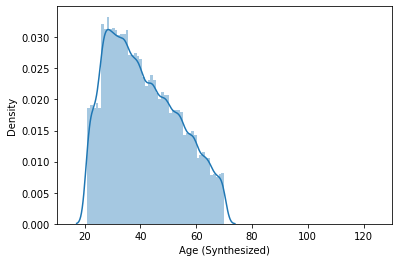

In [29]:
ax = sns.distplot(df_reverse['Age']);
plt.xlim(10, 130);
ax.set(xlabel='Age (Synthesized)');
plt.savefig('figs/eda/age_hist_syn_ageCat70.png',bbox_inches='tight')

In [30]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [31]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
0  bank_account   53785  55.406185
1   credit_card   43289  44.593815


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female   53162  54.764407
1            male   43912  45.235593


Normalized Retailer
       Normalized Retailer  Counts   Per (%)
1346           Tim Hortons    5861  6.037662
1435               Walmart    3966  4.085543
981           Petro-Canada    2989  3.079094
25                  Amazon    1619  1.667800
1166                 Shell    1599  1.647197
...                    ...     ...       ...
935        Osh Kosh B'gosh       1  0.001030
931             Organigram       1  0.001030
930   Orangetheory Fitness       1  0.001030
925             Olly Shoes       1  0.001030
0            1 For 1 Pizza       1  0.001030

[1503 rows x 3 columns]


SIC Description
                                     SIC Description  Counts    Per (%)
3                                      Eating Places   29538  30.428333
6   

barplot for SIC Description


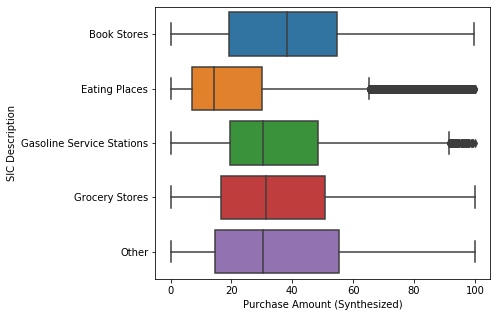

barplot for Normalized Retailer


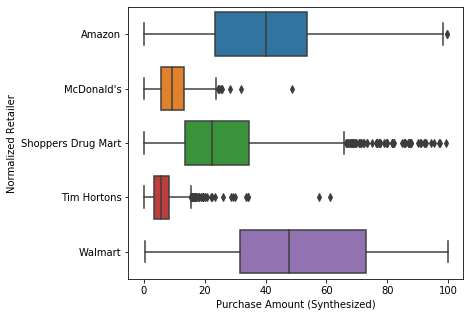

In [32]:
check_list = ['SIC Description','Normalized Retailer']
SIC_list = ['Eating Places','Gasoline Service Stations','Other','Grocery Stores','Book Stores']
retailer_list = ['Amazon','Tim Hortons',"McDonald's","Shoppers Drug Mart","Walmart"]

fig_dims = [6, 5] 
#N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    if cat == 'SIC Description':
        list_tmp = SIC_list
    else:
        list_tmp = retailer_list
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount Corrected'] < threshold)].sort_values(by = cat)
   
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount Corrected'])
    ax.set(xlabel='Purchase Amount (Synthesized)')
    #plt.savefig('figs/eda/purchase_' + cat + '_synthesized.png',bbox_inches='tight')
    plt.show()